# Session 9 - Post-double Selection

## Contents

- [Frisch-Waugh Theorem](#Frisch-Waugh-Theorem)
- [Omitted Variable Bias](#Omitted-Variable-Bias)
- [Pre-Test Bias](#Pre-Test-Bias)
- [Post-double selection](#Post-double-selection)
- [Double/debiased machine learning](#Double/debiased-machine-learning)


In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Frisch-Waugh theorem

Consider the data $D = \{ x_i, y_i, z_i \}_{i=1}^n$ with DGP:

$$
y_i = x_i' \alpha_0+ z_i' \beta_0 + \varepsilon_i
$$

. The following estimators of $\alpha$ are numerically equivalent (if $[x, z]$ has full rank):

- OLS: $\hat{\alpha}$ from regressing $y$ on $x, z$
- Partialling out: $\tilde{\alpha}$ from regressing $y$ on $\tilde{x}$
- "Double" partialling out: $\bar{\alpha}$ from regressing $\tilde{y}$ on $\tilde{x}$

where the operation of passing to $y, x$ to $\tilde{y}, \tilde{x}$ is called *projection  out $z$*, e.g. $\tilde{x}$ are the residuals from regressing $x$ on $z$.

$$
\tilde{x} = x - \hat \gamma z = (I - z (z' z)^{-1} z' ) x = (I-P_z) x = M_z x
$$

I.e we have done the following:
 1. regress $x$ on $z$
 2. compute $\hat x$
 3. compute the residuals $\tilde x = x - \hat x$
 
We now explore the theorem through simulation. In particular, we generate a sample from the following model:

$$
y_i = x_i - 0.3 z_i + \varepsilon_i
$$

where $x_i,z_i,\varepsilon_i \sim N(0,1)$ and $n=1000$.

In [3]:
np.random.seed(1)

# Init
n = 1000
a = 1
b = -.3

# Generate data
x = np.random.uniform(0,1,n).reshape(-1,1)
z = np.random.uniform(0,1,n).reshape(-1,1)
e = np.random.normal(0,1,n).reshape(-1,1)
y = a*x + b*z + e

In [4]:
# Estimate alpha by OLS
xz = np.concatenate([x,z], axis=1)
ols_coeff = inv(xz.T @ xz) @ xz.T @ y
alpha_ols = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_ols, a))

alpha OLS: 1.0928 (true=1)


In [5]:
# Partialling out
x_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ x
alpha_po = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y

print('alpha partialling out: %.4f (true=%1.0f)' % (alpha_po, a))

alpha partialling out: 1.0928 (true=1)


In [6]:
# "Double" partialling out
y_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ y
alpha_po2 = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y_tilde

print('alpha double partialling out: %.4f (true=%1.0f)' % (alpha_po2, a))

alpha double partialling out: 1.0928 (true=1)


## Omitted Variable Bias

Consider two separate statistical models. Assume the following **long regression** of interest:

$$
y_i = x_i' \alpha_0+ z_i' \beta_0 + \varepsilon_i
$$

Define the corresponding **short regression** as

$$
  y_i = x_i' \alpha_0 + v_i \quad \text{ with } \quad x_i = z_i' \beta_0 + u_i
$$

**OVB Theorem**:
Suppose that the DGP for the long regression corresponds to $\alpha_0$, $\beta_0$. Suppose further that $\mathbb E[x_i] = 0$, $\mathbb E[z_i] = 0$, $\mathbb E[\varepsilon_i |x_i,z_i] = 0$. Then, unless $\beta_0 = 0$ or $z_i$ is orthogonal to $x_i$, the (sole) stochastic regressor $x_i$ is correlated with the error term in the short regression which implies that the OLS estimator of the short regression is inconsistent for $\alpha_0$ due to the omitted variable bias. In particular, one can show that the plim of the OLS estimator of $\hat{\alpha}_{SHORT}$ from the short regression is
$$
\hat{\alpha}_{SHORT} \overset{p}{\to} \frac{Cov(y_i, x_i)}{Var(x_i)} = \alpha_0 + \beta_0 \frac{Cov(z_i, x_i)}{Var(x_i)}
$$

Consider data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

Let's investigate the Omitted Variable Bias by simulation. In particular, we generate a sample from the following model:

$$
\begin{aligned}
& y_i = x_i - 0.3 z_i + \varepsilon_i \\
& x_i = 3 z_i + u_i \\
\end{aligned}
$$

where $z_i,\varepsilon_i,u_i \sim N(0,1)$ and $n=1000$.

In [7]:
def generate_data(a, b, c, n):

    # Generate data
    z = np.random.normal(0,1,n).reshape(-1,1)
    u = np.random.normal(0,1,n).reshape(-1,1)
    x = c*z + u
    e = np.random.normal(0,1,n).reshape(-1,1)
    y = a*x + b*z + e
    
    return x, y, z

In [8]:
# Init
n = 1000
a = 1
b = -.3
c = 3
x, y, z = generate_data(a, b, c, n)

# Estimate alpha by OLS
ols_coeff = inv(x.T @ x) @ x.T @ y
alpha_short = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_short, a))

alpha OLS: 0.9115 (true=1)


In our case the expected bias is:

$$
\begin{aligned}
Bias & = \beta_0 \frac{Cov(z_i, x_i)}{Var(x_i)} = \\
& = \beta_0 \frac{Cov(z_i' \gamma_0 + u_i, x_i)}{Var(z_i' \gamma_0 + u_i)} = \\
& = \beta_0 \frac{\gamma_0 Var(z_i)}{\gamma_0^2 Var(z_i) + Var(u_i)}
\end{aligned}
$$

which in our case is $b \frac{c}{c^2 + 1}$.

In [9]:
# Expected bias
bias = alpha_short - a
exp_bias = b * c / (c**2 + 1)

print('Empirical bias: %.4f \nExpected bias:  %.4f' % (bias, exp_bias))

Empirical bias: -0.0885 
Expected bias:  -0.0900


## Pre-test bias

Consider data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

Where $x_i$ is the variable of interest (we want to make inference on $\alpha_0$) and $z_i$ is a high dimensional set of control variables. 

From now on, we will work under the following assumptions:

- $\dim(x_i)=1$ for all $n$
- $\beta_0$ uniformely bounded in $n$
- Strict exogeneity: $\mathbb E[\varepsilon_i | x_i, z_i] = 0$ and $\mathbb E[u_i | z_i] = 0$
- $\beta_0$ and $\gamma_0$ have dimension (and hence value) that depend on $n$

Pre-Testing procedure:

1. Regress $y_i$ on $x_i$ and $z_i$
2. For each $j = 1, ..., p = \dim(z_i)$ calculate a test statistic $t_j$
3. Let $\hat{T} = \{ j: |t_j| > C > 0 \}$ for some constant $C$ (set of statistically significant coefficients).
4. Re-run the new "model" using $(x_i, z_{\hat{T},i})$ (i.e. using the selected covariates with statistically significant coefficients).
5. Perform statistical inference (i.e. confidence intervals and hypothesis tests) as if no model selection had been done.

Pre-testing leads to incorrect inference. Why? Because of test errors in the first stage.

In [10]:
# T-test
def t_test(y, x, k):
    beta_hat = inv(x.T @ x) @ x.T @ y
    residuals = y - x @ beta_hat
    sigma2_hat = np.var(residuals)
    beta_std = np.sqrt(np.diag(inv(x.T @ x)) * sigma2_hat )
    return beta_hat[k,0]/beta_std[k]

First of all the t-test for $H_0: \beta_0 = 0$:

$$
t = \frac{\hat \beta_k}{\hat \sigma_{\beta_k}}
$$

where the standard deviation of the ols coefficient is given by

$$
\hat \sigma_{\beta_k} = \sqrt{ \hat \sigma^2 \cdot (X'X)^{-1}_{[k,k]} }
$$

where we estimate the variance of the error term with the variance of the residuals

$$
\hat \sigma^2 = Var \big( y - \hat y \big) = Var \big( y - X (X'X)^{-1}X'y \big)
$$

In [11]:
# Pre-testing
def pre_testing(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        xz = np.concatenate([x,z], axis=1)
        
        # Compute coefficients
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y
        t = t_test(y, xz, 1)
        
        # Select specification based on test
        if np.abs(t)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
    
    return alpha

In [12]:
# Get pre_test alpha
alpha = pre_testing(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925


The pre-testing coefficient is much less biased than the short regression one. But it's still biased.

However, the main effect of pre-testing is on inference. With pre-testing, the distribution of the estimator is not gaussian anymore. 

In [13]:
def plot_alpha(alpha, a):
    
    fig = plt.figure(figsize=(17,6))

    # Plot distributions
    x_max = np.max([np.max(np.abs(x-a)) for x in alpha.values()])

    # All axes
    for i, key in enumerate(alpha.keys()):
        
        # Reshape exisiting subplots
        k = len(fig.axes)
        for i in range(k):
            fig.axes[i].change_geometry(1, k+1, i+1)
            
        # Add new plot
        ax = fig.add_subplot(1, k+1, k+1)
        ax.hist(alpha[key], bins=30)
        ax.set_title(key)
        ax.set_xlim([a-x_max, a+x_max])
        ax.axvline(a, c='r', ls='--')
        legend_text = [r'$\alpha_0=%.0f$' % a, r'$\hat \alpha=%.4f$' % np.mean(alpha[key])]
        ax.legend(legend_text, prop={'size': 10})

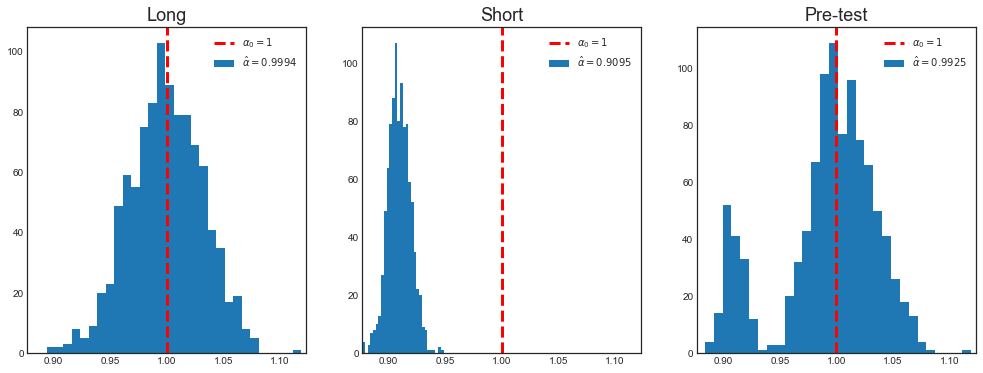

In [14]:
# Plot
plot_alpha(alpha, a)

As we can see, the main problem of pre-testing is inference.

Because of the testing procedure, the distribution of the estimator is a combination of tho different distributions: the one resulting from the long regression and the one resulting from the short regression. **Pre-testing is not a problem in 3 cases**:

 - when $\beta_0$ is very large: in this case the test always rejects the null hypothesis $H_0 : \beta_0=0$ and we always run the correct specification, i.e. the long regression
 
 - when $\beta_0$ is very small: in this case the test has very little power. However, as we saw from the Omitted Varaible Bias formula, the bias is small.
 
 - when $\gamma_0$ is very small: also in this case the test has very little power. However, as we saw from the Omitted Varaible Bias formula, the bias is small.

In [15]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = pre_testing(a, b_, c, n)['Pre-test']
    print('Mean with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

Mean with beta=-0.03: 0.9926
Mean with beta=-0.09: 0.9826
Mean with beta=-0.30: 0.9925
Mean with beta=-0.90: 0.9994


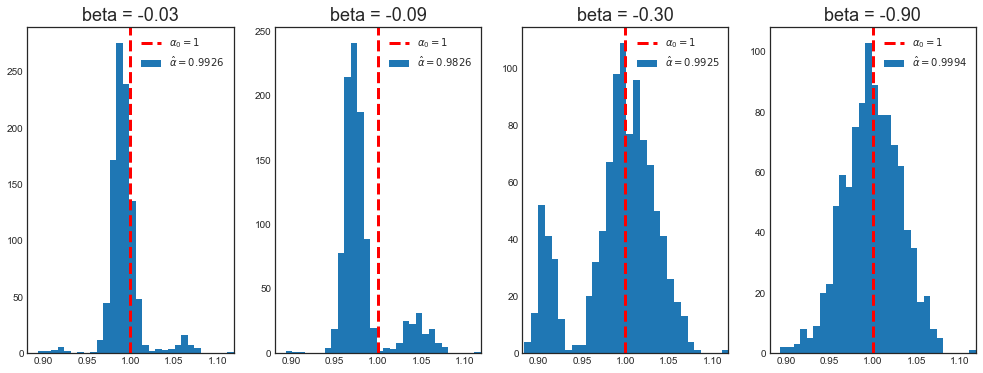

In [16]:
# Plot
plot_alpha(alpha, a)

However, the magnitue of $\beta_0$ is a relative concept. For an infinite sample size, $\beta_0$ is always going to be "big enough", in the sense that with an infinite sample size the probability fo false positives in testing $H_0: \beta_0 = 0$ is going to zero. I.e. we always select the correct model specification, the long regression.

Let's have a look at the distibution of $\hat \alpha_{\text{PRE-TEST}}$ when the sample size increaes.

In [17]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, b, c, n_)['Pre-test']
    print('Mean with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean with n=100: 0.9442
Mean with n=300: 0.9635
Mean with n=1000: 0.9925
Mean with n=3000: 0.9989


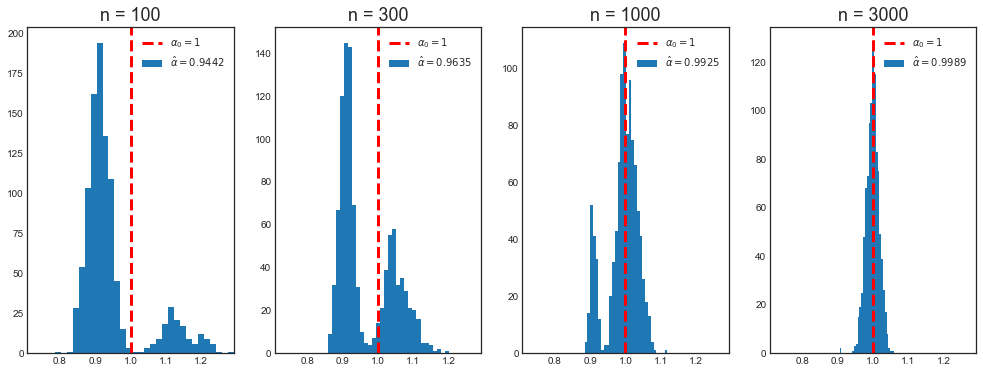

In [18]:
# Plot
plot_alpha(alpha, a)

As we can see, for large samples, $\beta_0$ is never "small". In the limit, when $n \to \infty$, the probability of false positives while testing $H_0: \beta_0 = 0$ goes to zero. 

We face a dilemma:
 - pre-testing is clearlly a problem in finite samples
 - all our econometric results are based on the assumption that $n \to \infty$

The problem is solved by assuming that the value of $\beta_0$ depends on the sample size. This might seems like a weird assumption but is just to have an asymptotically meaningful concept of "big" and "small".

We now look at what happens in the simulations when $beta_0$ is proportional to $\frac{1}{\sqrt{n}}$.

In [42]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, beta[k], c, n_)['Pre-test']
    print('Mean with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean with n=100: 0.9703
Mean with n=300: 0.9838
Mean with n=1000: 0.9914
Mean with n=3000: 0.9947


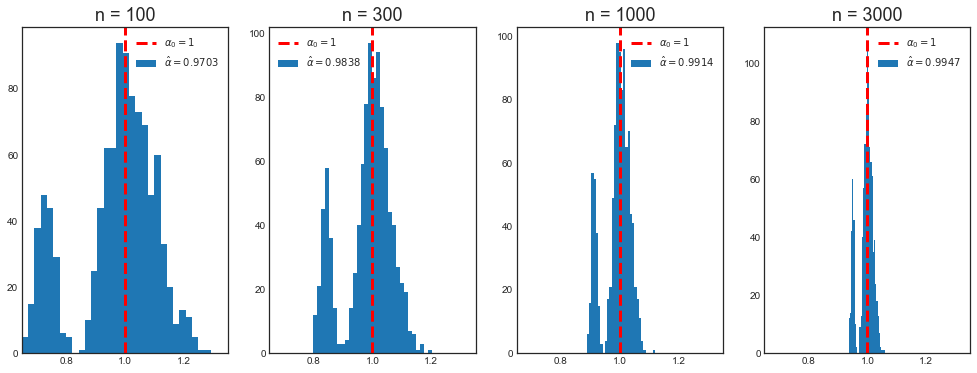

In [43]:
# Plot
plot_alpha(alpha, a)

Note that the estimator is consistent. But confidence interval coverage is wrong.

### Pre-testing and Machine Learning

How are machine learning and pre-testing related? The best example is Lasso. Suppose you have a dataset with many variables. This means that you have very few degrees of freedom and your OLS estimates are going to be very imprecise. At the extreme, you have more variables than observations so that your OLS coefficient is undefined since you cannot invert the design matrix $X'X$.

In this case, you might want to do variable selection. One way of doing variable selection is pre-testing. Another way is Lasso. A third alternative is to use machine learning methods that do not suffer this curse of dimensionality.

The purpose and outcome of pre-testing and Lasso are the same:

 - you have too many variables
 - you exclude some of them from the regression / set their coefficients to zero
 
As a consequence, also the problems are the same, i.e. pre-test bias.

## Post-double selection

Consider again data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

We would like to guard against pretest bias if possible, in order to handle high dimensional models. A good pathway towards motivating procedures which guard against pretest bias is a discussion of classical partitioned regression.

Consider a regression $y_i$ on $x_i$ and $z_i$. $x_i$ is the 1-dimensional variable of interest, $z_i$ is a high-dimensional set of control variables. We have the following procedure:

1. **First Stage** selection: regress $x_i$ on $z_i$. Select the statistically significant variables in the set $S_{FS} \subseteq z_i$
2. **Reduced Form** selection: lasso $y_i$ on $z_i$. Select the statistically significant variables in the set $S_{RF} \subseteq z_i$
3. Regress $y_i$ on $x_i$ and $S_{FS} \cup S_{RF}$


**Theorem**:
Let $\{P^n\}$ be a sequence of data-generating processes for $D_n = (y_i, x_i, z_i)^n_{i=1} \in (\mathbb R \times \mathbb R \times \mathbb R^p) ^n$ where $p$ depends on $n$. For each $n$, the data are iid with $yi =  x_i'\alpha_0^{(n)} + z_i' \beta_0^{(n)} + \varepsilon_i$ and $x_i = z_i' \gamma_0^{(n)} + u_i$ where $\mathbb E[\varepsilon_i | x_i,z_i] = 0$ and $\mathbb E[u_i|z_i] = 0$. The sparsity of the vectors  $\beta_0^{(n)}$, $\gamma_0^{(n)}$ is controlled by $|| \beta_0^{(n)} ||_0 \leq s$ with $s^2 (\log p)^2/n \to 0$. Suppose that additional regularity conditions on the model selection procedures and moments of the random variables $y_i$ , $x_i$ , $z_i$ as documented in Belloni et al. (2014). Then the confidence intervals, CI, from the post double selection procedure are uniformly valid. That is, for any confidence level $\xi \in (0, 1)$
$$
		\Pr(\alpha_0 \in CI) \to 1- \xi
$$

In order to have valid confidence intervals you want their bias to be negligibly. Since
$$
  CI = \left[ \hat{\alpha} \pm \frac{1.96 \cdot \hat{\sigma}}{\sqrt{n}} \right]
$$

If the bias is $o \left( \frac{1}{\sqrt{n}} \right)$ then there is no problem since it is asymptotically negligible w.r.t. the magnitude of the confidence interval. If however the the bias is $O \left( \frac{1}{\sqrt{n}} \right)$ then it has the same magnitude of the confidence interval and it does not asymptotically vanish. 

The idea of the proof is to use partitioned regression. An alternative way to think about the argument is: bound the omitted variables bias. Omitted variable bias comes from the product of 2 quantities related to the omitted variable:

1. Its partial correlation with the outcome, and
2. Its partial correlation with the variable of interest.

If both those partial correlations are $O( \sqrt{\log p/n})$, then the omitted variables bias is $(s \times O( \sqrt{\log p/n})^2 = o \left( \frac{1}{\sqrt{n}} \right)$, provided $s^2 (\log p)^2/n \to 0$. Relative to the $ \frac{1}{\sqrt{n}} $ convergence rate, the omitted variables bias is negligible. 

In our omitted variable bias case, we want $| \beta_0 \gamma_0 | = o \left( \frac{1}{\sqrt{n}} \right)$.  Post-double selection guarantees that 

- *Reduced form* selection (pre-testing): any "missing" variable has $|\beta_{0j}| \leq \frac{c}{\sqrt{n}}$
- *First stage* selection (additional): any "missing" variable has $|\gamma_{0j}| \leq \frac{c}{\sqrt{n}}$


As a consequence, as long as the number of omitted variables is finite, the omitted variable bias is 
$$
	OVB(\alpha) = |\beta_{0j}| \cdot|\gamma_{0j}| \leq \frac{c}{\sqrt{n}} \cdot \frac{c}{\sqrt{n}} = \frac{c^2}{n} = o \left(\frac{1}{\sqrt{n}}\right)
$$

In [21]:
# Pre-testing code
def post_double_selection(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1)),
            'Post-double': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y (beta hat)
        t1 = t_test(y, xz, 1)
        
        # Compute significance of z on x (gamma hat)
        t2 = t_test(x, z, 0)
        
        # Select specification based on first test
        if np.abs(t1)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
            
        # Select specification based on both tests
        if np.abs(t1)>1.96 or np.abs(t2)>1.96:
            alpha['Post-double'][i] = alpha['Long'][i]
        else:
            alpha['Post-double'][i] = alpha['Short'][i]
    
    return alpha

In [22]:
# Get pre_test alpha
alpha = post_double_selection(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925
Mean alpha Post-double = 0.9994


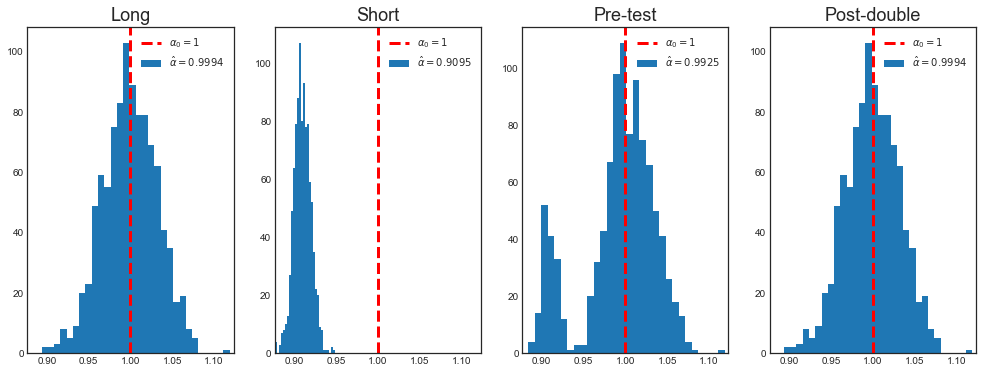

In [23]:
# Plot
plot_alpha(alpha, a)

As we can see, post-double selection has solved the pre-testing problem. Does it work for any magnitude of $\beta$ (relative to the sample size)?

We first have a look at the case in which the sample size is fixed and $\beta_0$ changes.

In [24]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = post_double_selection(a, b_, c, n)['Post-double']
    print('Mean with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

Mean with beta=-0.03: 0.9994
Mean with beta=-0.09: 0.9994
Mean with beta=-0.30: 0.9994
Mean with beta=-0.90: 0.9994


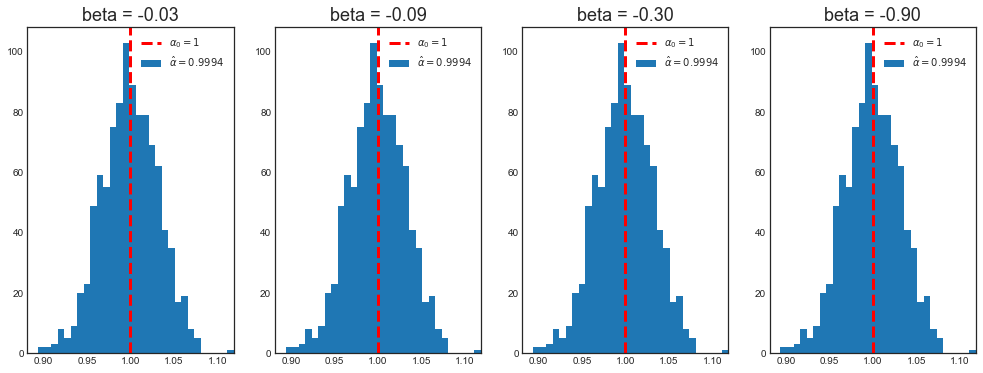

In [25]:
# Plot
plot_alpha(alpha, a)

Post-double selection always selects the correct specification, the long regression, even when $\beta$ is very small.

Now we check the same but for fixed $\beta_0$ and different sample sizes.

In [26]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, b, c, n_)['Post-double']
    print('Mean with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean with n=100: 0.9964
Mean with n=300: 0.9985
Mean with n=1000: 0.9994
Mean with n=3000: 0.9990


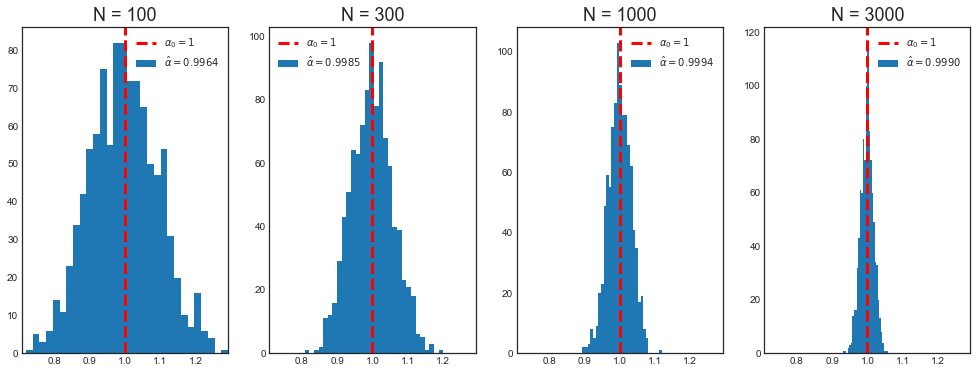

In [27]:
# Plot
plot_alpha(alpha, a)

Post-double selection always selects the correct specification, the long regression, even when the sample size is very small.

Last, we check the case of $\beta_0$ proportional to $\frac{1}{\sqrt{n}}$.

In [28]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, beta[k], c, n_)['Post-double']
    print('Mean with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean with n=100: 0.9964
Mean with n=300: 0.9985
Mean with n=1000: 0.9994
Mean with n=3000: 0.9990


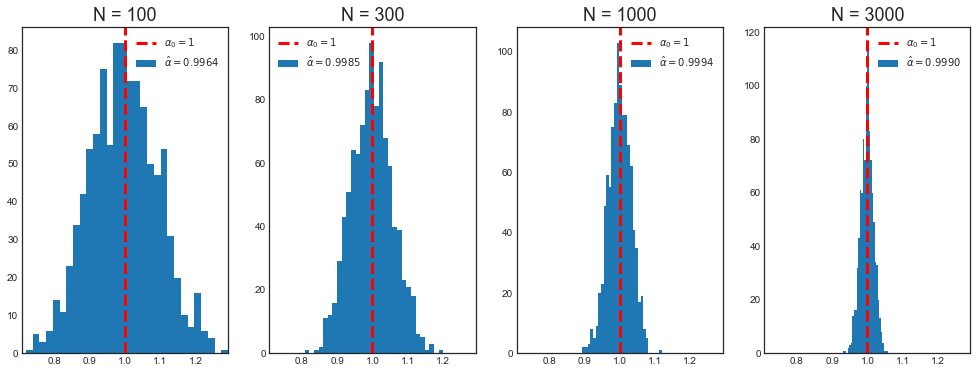

In [29]:
# Plot
plot_alpha(alpha, a)

Once again post-double selection always selects the correct specification, the long regression.

### Post-double selection and Machine Learning

As we have seen at the end of the previous section, Lasso can be used to perform variable selection in high dimensional settings. Therefore, post-double selection solves the pre-test bias problem in those settings. The post-double selection procedure with Lasso is:

1. **First Stage** selection: lasso $x_i$ on $z_i$. Let the selected variables be collected in the set $S_{FS} \subseteq z_i$
2. **Reduced Form** selection: lasso $y_i$ on $z_i$. Let the selected variables be collected in the set $S_{RF} \subseteq z_i$
3. Regress $y_i$ on $x_i$ and $S_{FS} \cup S_{RF}$

## Double/debiased machine learning

This section is taken from [Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). "*Double/debiased machine learning for treatment and structural parameters*"](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097).

Consider the following partially linear model

$$
y = \beta_0 D + g_0(X) + u \\
D = m_0(X) + v
$$

where $y$ is the outcome variable, $D$ is the treatment to interest and $X$ is a potentially high-dimensional set of controls.

#### Naive approach

A naive approach to estimation of $\beta_0$ using ML methods would be, for example, to construct a sophisticated ML estimator $\beta_0 D + g_0(X)$ for learning the regression function $\beta_0 D$ + $g_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$
3. Use the main sample to compute the orthogonalized component of $Y$ on $X$: $\hat u = \left(Y_{i}-\hat{g}_{0}\left(X_{i}\right)\right)$ 
3. Use the main sample to estimate the residualized OLS estimator

$$
\hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} D_{i}^{2}\right)^{-1} \frac{1}{n} \sum_{i \in I} D_{i} \hat u_i
$$

This estimator is going to have two problems:

1. Slow rate of convergence, i.e. slower than $\sqrt(n)$
2. It will be biased because we are employing highdimensional regularized estimators (e.g. we are doing variable selection)

#### Orthogonalization

Now consider a second construction that employs an orthogonalized formulation obtained by directly partialling out the effect of $X$ from $D$ to obtain the orthogonalized regressor $v = D − m_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$ from
    
    $$
    y = \beta_0 D + g_0(X) + u \\
    $$


3. Use the auxiliary sample to estimate $\hat m_0(X)$ from

    $$
    D = m_0(X) + v
    $$


4. Use the main sample to compute the orthogonalized component of $D$ on $X$ as

    $$
    \hat v = D - \hat m_0(X)
    $$
    
    
5. Use the main sample to estimate the double-residualized OLS estimator as

    $$
    \hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat v_i D_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat v_i \left( Y - \hat g_0(X) \right)
    $$


The estimator is unbiased but still has a lower rate of convergence because of sample splitting. The problem is solved by inverting the split sample, re-estimating the coefficient and averaging the two estimates. Note that this procedure is valid since the two estimates are independent by the sample splitting procedure.

### Application to AJR02

In this section we are going to replicate 6.3 of the "*Double/debiased machine learning*" paper based on [Acemoglu, Johnson, Robinson (2002), "*The Colonial Origins of Comparative Development*"](https://economics.mit.edu/files/4123).

We first load the dataset

In [3]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv',index_col=0)

In [4]:
df.head()

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort,Latitude2
1,8.39,6.50,78.20,0.3111,0,1,0,0,0,4.359270,0.096783
2,7.77,5.36,280.00,0.1367,0,1,0,0,0,5.634790,0.018687
3,9.13,6.39,68.90,0.3778,0,0,0,0,1,4.232656,0.142733
4,9.90,9.32,8.55,0.3000,1,0,0,0,0,2.145931,0.090000
5,9.29,7.50,85.00,0.2683,0,0,0,1,0,4.442651,0.071985


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 1 to 64
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GDP        64 non-null     float64
 1   Exprop     64 non-null     float64
 2   Mort       64 non-null     float64
 3   Latitude   64 non-null     float64
 4   Neo        64 non-null     int64  
 5   Africa     64 non-null     int64  
 6   Asia       64 non-null     int64  
 7   Namer      64 non-null     int64  
 8   Samer      64 non-null     int64  
 9   logMort    64 non-null     float64
 10  Latitude2  64 non-null     float64
dtypes: float64(6), int64(5)
memory usage: 6.0 KB


In their paper, AJR note that their IV strategy will be invalidated if other factors are also highly persistent and related to the development of institutions within a country and to the country’s GDP. A leading candidate for such a factor, as they discuss, is geography. AJR address this by assuming that the confounding effect of geography is adequately captured by a linear term in distance from the equator and a set of continent dummy variables. 

They inclue their results in table 2.

In [6]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]
y = df['GDP']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

In [7]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const','Exprop','Latitude','Latitude2'])

results_table

,Model 1,Model 2,Model 3
const,4.66***,4.55***,5.95***
,(0.41),(0.45),(0.68)
Exprop,0.52***,0.49***,0.40***
,(0.06),(0.07),(0.06)
Latitude,,2.16,0.42
,,(1.68),(1.47)
Latitude2,,-2.12,0.44
,,(2.86),(2.48)
Asia,,,-0.74*
,,,(0.42)


Using DML allows us to relax this assumption and to replace it by a weaker assumption that geography can be sufficiently controlled by an unknown function of distance from the equator and continent dummies, which can be learned by ML methods.

In particular, our framework is

$$
{GDP} = \beta_0 \times {Exprop} + g_0({geography}) + u \\
{Exprop} = m_0({geography}) + u
$$

So that the double/debiased machine learning procedure is

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0({geography})$ from

    $$
    {GDP} = \beta_0 \times {Exprop} + g_0({geography}) + u
    $$


3. Use the auxiliary sample to estimate $\hat m_0({geography})$ from

    $$
    {Exprop} = m_0({geography}) + v
    $$


4. Use the main sample to compute the orthogonalized component of ${Exprop}$ on ${geography}$ as

    $$
    \hat v = {Exprop} - \hat m_0({geography})
    $$


5. Use the main sample to estimate the double-residualized OLS estimator as

    $$
    \hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat v_i \times {Exprop}_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat v_i \times \left( {GDP} - \hat g_0({geography}) \right)
    $$

Since we employ an **intrumental variable** strategy, we replace $m_0({geography})$ with $m_0({geography},{logMort})$ in the first stage.

In [8]:
# Generate variables
D = df['Exprop'].values.reshape(-1,1)
X = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']].values
y = df['GDP'].values.reshape(-1,1)
Z = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer','logMort']].values

Now we write down the whole procedure.

In [9]:
def estimate_beta(algorithm, alg_name, D, X, y, Z, sample):

    # Split sample
    D_main, D_aux = (D[sample==1], D[sample==0])
    X_main, X_aux = (X[sample==1], X[sample==0])
    y_main, y_aux = (y[sample==1], y[sample==0])
    Z_main, Z_aux = (Z[sample==1], Z[sample==0])

    # Residualize y on D
    b_hat = inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    y_resid_aux = y_aux - D_aux @ b_hat
    
    # Estimate g0
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid_aux.ravel())
    g0 = alg_fitted.predict(X_main).reshape(-1,1)

    # Compute v_hat
    u_hat = y_main - g0

    # Estimate m0
    alg_fitted = algorithm.fit(X=Z_aux, y=D_aux.ravel())
    m0 = algorithm.predict(Z_main).reshape(-1,1)
    
    # Compute u_hat
    v_hat = D_main - m0

    # Estimate beta
    beta = inv(v_hat.T @ D_main) @ v_hat.T @ u_hat
        
    return beta 

In [10]:
def ddml(algorithm, alg_name, D, X, y, Z, p=0.5, verbose=False):
    
    # Expand X if Lasso or Ridge
    if alg_name in ['Lasso   ','Ridge   ']:
        X = PolynomialFeatures(degree=2).fit_transform(X)

    # Generate split (fixed proportions)
    split = np.array([i in train_test_split(range(len(D)), test_size=p)[0] for i in range(len(D))])
    
    # Compute beta
    beta = [estimate_beta(algorithm, alg_name, D, X, y, Z, split==k) for k in range(2)]
    beta = np.mean(beta)
     
    # Print and return
    if verbose:
        print('%s : %.4f' % (alg_name, beta))
    return beta

In [20]:
p = 0.5
split = np.random.binomial(1, p, len(D))
split

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1])

We now repeat the same process with different algorithms. In particular, we consider:

1. Lasso Regression
2. Ridge Regression
3. Regression Trees
4. Random Forest
5. Boosted Forests

In [38]:
# List all algorithms
algorithms = {'Ridge   ': Ridge(alpha=.1),
              'Lasso   ': Lasso(alpha=.01),
              'Tree    ': DecisionTreeRegressor(),
              'Forest  ': RandomForestRegressor(n_estimators=30),
              'Boosting': GradientBoostingRegressor(n_estimators=30)}

In [39]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, Z, verbose=True)

Ridge    : -0.2711
Lasso    : 9.5116
Tree     : -1.2490
Forest   : 0.4924
Boosting : 1.4658


In [40]:
# Repeat K times
def estimate_beta_median(algorithms, D, X, y, Z, K):
    
    # Loop over algorithms
    for alg_name, algorithm in algorithms.items():
        betas = []
            
        # Iterate n times
        for k in range(K):
            beta = ddml(algorithm, alg_name, D, X, y, Z)
            betas = np.append(betas, beta)
    
        print('%s : %.4f' % (alg_name, np.median(betas)))

In [41]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, Z, 100)

Ridge    : 0.6670
Lasso    : 1.2511
Tree     : 0.9605
Forest   : 0.5327
Boosting : 1.0338


The results differ slightly from the ones in the paper.